In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import copy
import os
import json
import time

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import transforms, utils, datasets, models
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Build Dataset

In [ ]:
class RescalePadToTensor(object):
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size

    def __call__(self, img):
        img = img.transpose((2, 0, 1))
        img = torch.Tensor(img.copy())
        C, H, W = img.shape

        # Resize and pad to minimize distortion, maintaining aspect ratio
        if H == W:
            new_img = transforms.Resize((self.output_size, self.output_size))(img)
        elif H > W:
            prop = W/H
            new_W = int(self.output_size*prop)
            new_img = transforms.Resize((self.output_size, new_W))(img)

            is_odd = (self.output_size - new_W)%2
            pad_size = (self.output_size - new_W)//2
            new_img = transforms.Pad([pad_size, 0, pad_size+is_odd, 0], padding_mode='edge')(new_img)
        else:
            prop = H/W
            new_H = int(self.output_size*prop)
            new_img = transforms.Resize((new_H, self.output_size))(img)

            is_odd = (self.output_size - new_H)%2
            pad_size = (self.output_size - new_H)//2
            new_img = transforms.Pad([0, pad_size, 0, pad_size+is_odd], padding_mode='edge')(new_img)
        return new_img


class TransposeToTensor(object):
    def __call__(self, img):
        img = img.transpose((2, 0, 1))
        new_img = torch.Tensor(img.copy())
        return new_img


In [ ]:
class LegoDataset(Dataset):

    def __init__(self, split, transform=None, root_dir='drive/MyDrive/_porter_lego_data/porter_data', seed=42, has_test=False):
        """
        Args:
         - split (str): train, val, or test split
        """
        self.root_dir = root_dir
        self.image_folder = datasets.ImageFolder(root=self.root_dir) # imgs is the attribute where everything lives
        self.class_names = self.image_folder.classes

        # Train/Val/Test - 70/10/20
        X, y = map(list, zip(*self.image_folder.imgs))

        if split is None:
            self.imgs, self.labels = (X, y)
        elif has_test:
            _X, X_test, _y, y_test = train_test_split(X, y, test_size=.2, random_state=seed)
            X_train, X_val, y_train, y_val = train_test_split(_X, _y, test_size=.125, random_state=seed)

            splits = {'train': (X_train, y_train),
                        'val':(X_val, y_val),
                        'test': (X_test, y_test)}

            if split not in splits:
                raise ValueError('Invalid split name')
            self.imgs, self.labels = splits[split]
        else:
            X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=seed)
            splits = {'train': (X_train, y_train),
                        'val':(X_val, y_val)}

            if split not in splits:
                raise ValueError('Invalid split name')
            self.imgs, self.labels = splits[split]

        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.imgs[idx]
        image = plt.imread(img_name)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
class TorchImageShower:
    def __init__(self, pretrained_tform):
        self.pretrained_tform = pretrained_tform
        self.std = torch.Tensor(pretrained_tform.std)
        self.mean = torch.Tensor(pretrained_tform.mean)

    def show(self, img: np.ndarray, display=True) -> None:
        img_out = img * self.std.view(3, 1, 1) + self.mean.view(3, 1, 1)
        plt.imshow(img_out.long().numpy().transpose(1, 2, 0))
        if display:
            plt.show()

In [ ]:
# pretrained_transforms = models.ResNet50_Weights.IMAGENET1K_V2.transforms()
pretrained_transforms = models.MobileNet_V3_Large_Weights.IMAGENET1K_V2.transforms()

image_shower = TorchImageShower(pretrained_transforms)
batch_size = 32

inference_transforms = transforms.Compose([
    TransposeToTensor(),
    pretrained_transforms,
])

# Resize, pad, rotate, translate, scale, blur, flip
train_transforms = transforms.Compose([
    inference_transforms,
    transforms.RandomAffine(degrees=(0, 90)),
    transforms.GaussianBlur(kernel_size=3),
    transforms.RandomHorizontalFlip(),
])

train_path = 'drive/MyDrive/_porter_lego_data/porter_data/train'
val_path = 'drive/MyDrive/_porter_lego_data/porter_data/val'

train_dataset = LegoDataset(split=None, transform=train_transforms, root_dir=train_path)
val_dataset = LegoDataset(split=None, transform=inference_transforms, root_dir=val_path)

train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

dataloaders = {'train': train_dl,
               'val': val_dl}
dataset_sizes = {'train': len(train_dataset),
                'val': len(val_dataset)}
class_names = train_dataset.class_names

{'train': 1125, 'val': 130}
['2x2', '2x4', 'blank']


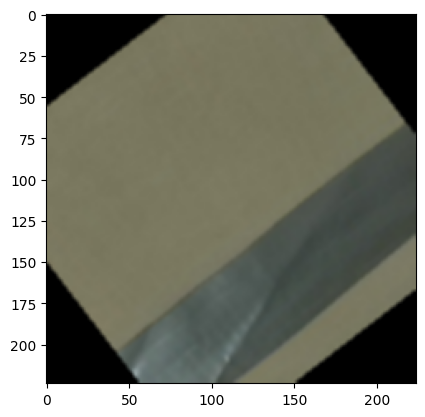

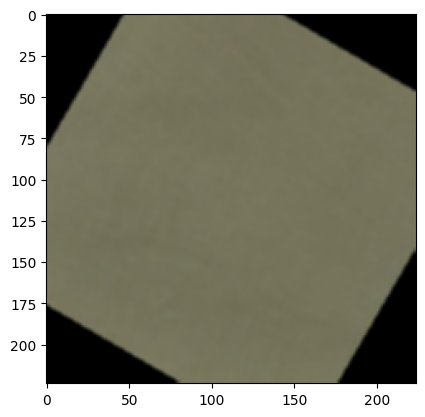

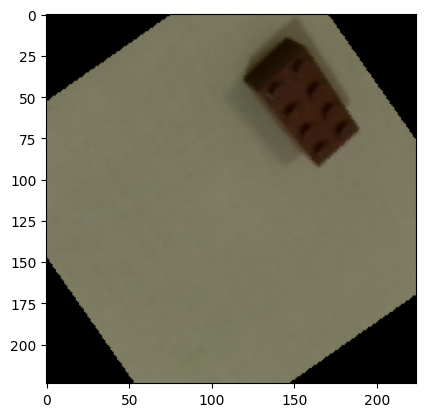

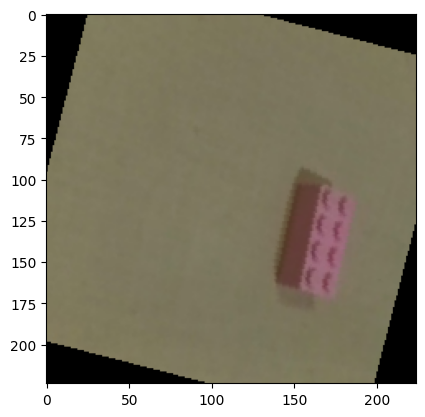

In [ ]:
print(dataset_sizes)
print(class_names)
for (x, y_truth) in train_dl:
    image_shower.show(x[0])
    image_shower.show(x[1])
    image_shower.show(x[2])
    image_shower.show(x[3])
    break

# Model

In [ ]:
# model = models.resnet50(weights="DEFAULT")
model = models.mobilenet_v3_large(weights="DEFAULT")

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 89.2MB/s]


In [ ]:
for param in model.parameters():
    param.requires_grad = False

out_ftrs = len(train_dataset.class_names)
print(out_ftrs)

# ### ResNet 50
# in_ftrs = model.fc.in_features
# model.fc = nn.Linear(in_ftrs, out_ftrs)
# parameters = model.fc.parameters()

### MobileNet V3 Large
in_ftrs = model.classifier[3].in_features
model.classifier[3] = nn.Linear(in_ftrs, out_ftrs)
parameters = model.classifier[3].parameters()

optimizer = optim.SGD(parameters, lr=0.001, momentum=0.9)
model = model.to(device)

3


# Training

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    loop = tqdm(total=num_epochs, position=0, leave=False)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_loss = np.inf
    train_acc = np.inf
    val_loss = np.inf
    val_acc = np.inf
    all_train_losses = []
    all_train_acc = []
    all_val_losses = []
    all_val_acc = []
    for epoch in range(num_epochs):

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() #* inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                train_loss = epoch_loss
                train_acc = epoch_acc
                all_train_losses.append(train_loss)
                all_train_acc.append(train_acc)
                loop.set_description(f'epoch:{epoch}, loss:{train_loss:.3f}, acc:{train_acc:.3f}, val_loss:{val_loss:.3f}, val_acc:{val_acc:.3f}, best_acc:{best_acc:.2f}')
                loop.update(1)
            else:
                val_loss = epoch_loss
                val_acc = epoch_acc.item()
                all_val_losses.append(val_loss)
                all_val_acc.append(val_acc)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())


    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, all_train_losses, all_train_acc, all_val_losses, all_val_acc

In [ ]:
torch.manual_seed(42)

criterion = nn.CrossEntropyLoss(reduction='sum')
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
num_epochs = 30

model, train_losses, train_accs, val_losses, val_accs = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=num_epochs)

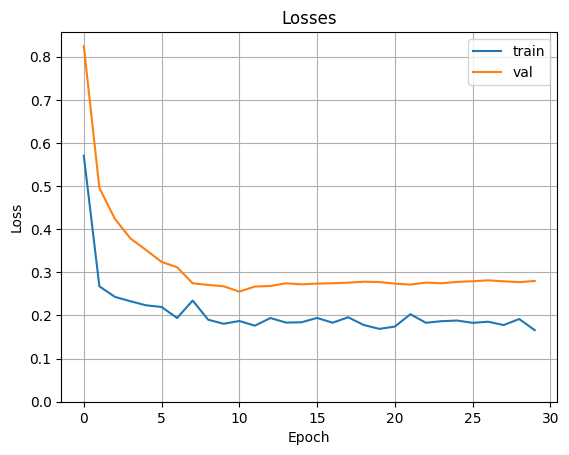

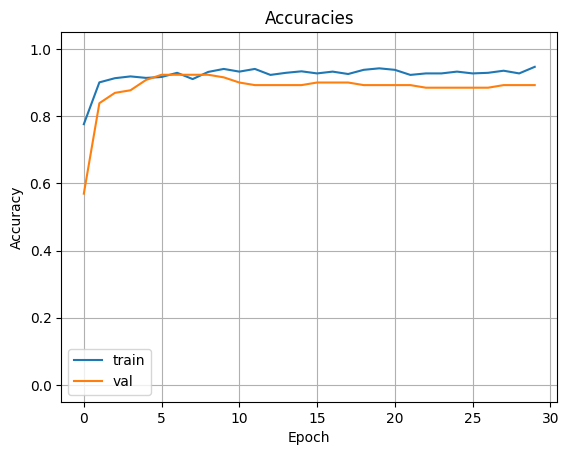

0.9230769230769231


In [ ]:
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.ylim(bottom=0)
plt.title('Losses')
plt.legend()
plt.show()

train_accs = [t.item() for t in train_accs]
plt.plot(np.arange(num_epochs), train_accs, label='train')
plt.plot(np.arange(num_epochs), val_accs, label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.ylim(-0.05, 1.05)
plt.title('Accuracies')
plt.legend()
plt.show()

print(max(val_accs))

In [ ]:
def visualize_model(model, image_shower: TorchImageShower, num_images=6, figsize=(10, 8)):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for (inputs, labels) in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for i in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//3, 3, images_so_far)
                ax.axis('off')
                ax.set_title('pred: {}\nactual: {}'.format(class_names[preds[i]], class_names[labels[i]]))
                # show_torch_img(inputs.cpu().data[i])
                image_shower.show(inputs.cpu().data[i], display=False)

                if images_so_far == num_images:
                    plt.tight_layout()
                    plt.gcf().set_size_inches(*figsize)
                    plt.show()
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

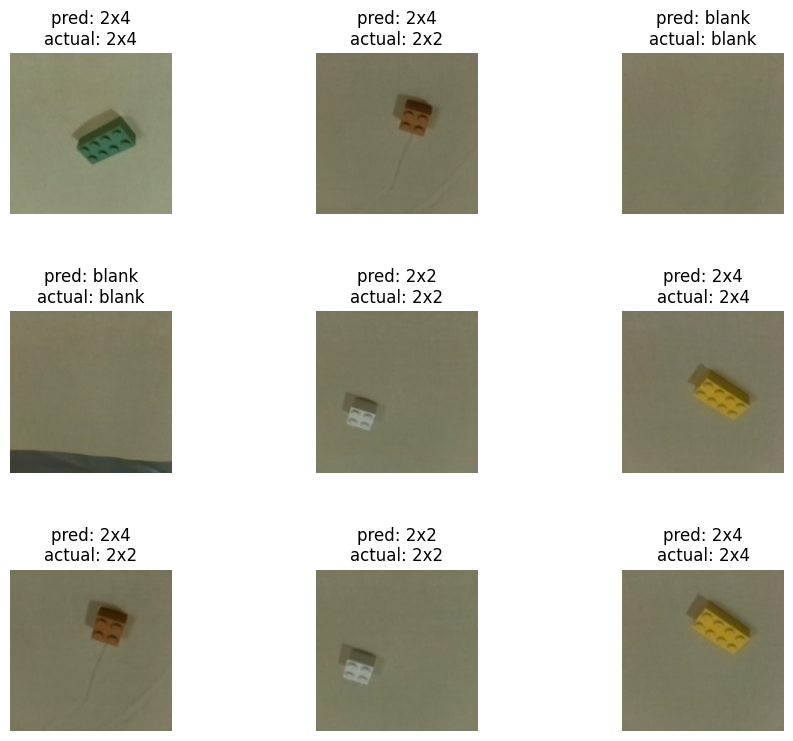

In [ ]:
visualize_model(model, image_shower, num_images=9)

## Save Model

In [ ]:
torch.save(model.state_dict(), 'mobilenetv3large_porter_data5.pt')